# Adaptive Ogata

In [1]:
import numpy as np
import sympy as sp
import pylab as py
import os
import heapq
%matplotlib inline
import vegas
from scipy.special import jv, jn_zeros, yv
import scipy.special as spec
from scipy.optimize import fsolve
from scipy.optimize import fmin
from scipy.integrate import quad
from scipy.optimize import fsolve
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
warnings.filterwarnings('ignore')
import time
from scipy.interpolate import interp1d

## integrators

In [2]:
def Quadinversion(w, q, nu, tau):
    quadreturn = quad(lambda bT: jv(nu,q*bT)*w(bT),0,np.inf, epsabs = 0, epsrel = tau)
    return 1/(2*np.pi)*quadreturn[0], 1/(2*np.pi)*quadreturn[1]

In [3]:
def transform(f, p):
    return f(np.tan(p))*(1/np.cos(p))**2

def MCinversion(f, q, nu, m):
    integ = vegas.Integrator([[0, np.pi/2.0]])
    result = integ(lambda p: 1/(2*np.pi)*transform(f, p)*jv(nu, q*np.tan(p)), nitn=10, neval=int(m))[0]
    lst = str(result).replace('+-', '(').replace(')', '(').split('(')
    num_zeros = 0
    if str(lst[0][0]) == '-':
        num_zeros = -1
    if len(lst[1]) == 3:
        integral = float(lst[0])
        try:
            error = float(lst[1])
        except:
            error = 0.0
    else:
        num_zeros = num_zeros+len(lst[0])-4
        lst[1] = '0.'+lst[1].zfill(num_zeros+2)
        integral = float(lst[0])
        try:
            error = float(lst[1])
        except:
            error = 0.0
    return integral, error

In [13]:
from inverters import AdOg
ogata = AdOg()
def adog(w, qT, nu, Nmax, Q):
    global counter
    return ogata.adog(w, qT, nu, Nmax, Q)
def adog2(w, qT, nu, eps, Q):
    global counter
    return ogata.adog2(w, qT, nu, Q,epsilon=eps,ib=1,it=1)

## toy TMD

In [14]:
def Wtilde(bT,Q,sigma):
    global counter
    counter += 1
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return bT**(a-1)*np.exp(-bT/b)/b**a/spec.gamma(a)

def W(qT, Q, sigma, nu):
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return 1/(2*np.pi)*spec.gamma(a+nu)/spec.gamma(a)*(b*qT/2.0)**nu*spec.hyp2f1((a+nu)/2.0, (a+nu+1.0)/2.0, nu+1.0, -qT**2.0*b**2.0)/spec.gamma(nu+1.0)

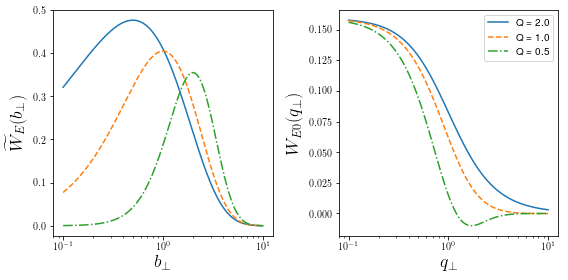

In [15]:
counter =0
bT=np.logspace(-1,1,400)
sigma = 0.8
Wb05=[Wtilde(b,0.5,sigma) for b in bT]
Wb1=[Wtilde(b,1.0,sigma) for b in bT]
Wb2=[Wtilde(b,2.0,sigma) for b in bT]
qT=np.logspace(-1,1,100)
Wq05=[W(q, 0.5, sigma, 0) for q in qT]
Wq1=[W(q, 1.0, sigma, 0) for q in qT]
Wq2=[W(q, 2.0, sigma, 0) for q in qT]
fig = py.figure(figsize=(8, 4))
ax=py.subplot(121)
#ax.plot(bT,Wb,label='Gamma')
ax.plot(bT,Wb2,label=r'$Q = 2.0$')
ax.plot(bT,Wb1,label=r'$Q = 1.0$',ls = '--')
ax.plot(bT,Wb05,label=r'$Q = 0.5$',ls = '-.')
ax.set_xlabel(r'$b_{\perp}$',fontsize=18)
ax.set_ylabel(r'$\widetilde{W}_E(b_{\perp})$',fontsize=18)
ax.semilogx()
ax=py.subplot(122)
ax.plot(qT,Wq2,label='Q = 2.0')
ax.plot(qT,Wq1,label='Q = 1.0',ls = '--')
ax.plot(qT,Wq05,label='Q = 0.5',ls = '-.')
ax.semilogx()
ax.legend()
ax.set_xlabel(r'$q_{\perp}',fontsize=18)
ax.set_ylabel(r'$W_{E0}(q_{\perp})$',fontsize=18)
py.tight_layout()
py.savefig('FUU.pdf')
py.show()
#print W

# data generator

In [16]:
def gen_data(nu,Q,q,sigma,epss,ns_vegas,ns_ogata,eps_ogata):
    global counter
    exact=W(q, Q, sigma, nu)
    w = np.vectorize(lambda bT: Wtilde(bT, Q, sigma))

    data={}
    
    data['quad']={'N':[],'ratio':[],'error':[],'time':[]}
    for eps in epss:
        counter = 1
        num=1
        Sum=[0.0,0.0]
        t0 = time.time()
        for i in range(num):
            result=Quadinversion(w, q, nu, eps)
            Sum[0]+=result[0]
            Sum[1]+=result[1]
        t1 = time.time()
        total = t1-t0
        data['quad']['N'].append(counter/2.0/float(len(range(num))))
        data['quad']['ratio'].append(Sum[0]/exact/float(len(range(num))))
        data['quad']['error'].append(Sum[1]/exact/float(len(range(num))))
        data['quad']['time'].append(total/float(len(range(num))))

    data['vegas']={'N':[],'ratio':[],'error':[],'time':[]}
    #data['vegas']={'error': [628.0889090742575, 157.99260796916585, 0.17594082835848454, 0.1189459794457536, 0.0888187651798215, 0.07028791166164776, 0.05753635972040749, 0.048083100880623245, 0.04193989257022753, 0.03674033733902498], 'ratio': [367.84006921262704, 40.569091266796434, 1.0160393922187174, 1.0085241831544043, 1.0034899297885675, 1.0014790900662909, 1.00168954903971, 1.0003704561057722, 1.0007345671821366, 1.0001478246752389], 'time': [0.032695806694030764, 0.049881547689437866, 0.06786613349914551, 0.21918909990787505, 0.11485900130271912, 0.1231822900056839, 0.1532144273996353, 0.17404665501117705, 0.18331420269012452, 0.19768976769447327], 'N': [22.0, 469.7672, 954.0048, 1454.7108, 1963.0299, 2479.8849, 3001.7164, 3527.22, 4056.074, 4589.2882]}
    for n in ns_vegas:
        num=1
        counter = 0
        Sum=[0.0,0.0]
        t0 = time.time()
        for i in range(num):
            result=MCinversion(w, q, nu, int(n)/10)
            Sum[0]+=result[0]**2
            Sum[1]+=result[1]
        t1 = time.time()
        total = t1-t0
        data['vegas']['N'].append(counter/2.0/len(range(num)))
        data['vegas']['ratio'].append(np.sqrt(Sum[0]/float(len(range(num))))/exact)
        data['vegas']['error'].append(Sum[1]/exact/float(len(range(num))))
        data['vegas']['time'].append(total/float(len(range(num))))
        
    #data['ogata']={'N':[],'ratio':[],'error':[]}
#    for eps in eps_ogata:
#        counter = 0
#        result=adog2(w, q, nu, eps,Q)
#        print result/exact
#        data['ogata']['N'].append(int(counter/2))
#        data['ogata']['ratio'].append(result/exact)
#        data['ogata']['error'].append(0.0)
        
    data['ogata']={'N':[],'ratio':[],'error':[],'time':[]}
#    data['ogata']={'error': [-0.05728722021930712, -0.030697770539287135, -0.003188490908364063, 0.0006080165379194054, 5.0938418085450984e-05, 1.547627435300078e-05, 6.792226955261638e-06, 3.6840983847367883e-06, 9.767928868979559e-07, 2.4773966365538736e-07], 'ratio': [0.9812291604391767, 1.0091238741292294, 0.9983173719315273, 1.0002714080486053, 1.000473024710833, 1.000466188476558, 1.0004413568929835, 1.0004340910366751, 1.0004279163039467, 1.000426270826803], 'time': [0.0008001327514648438, 0.0011599063873291016, 0.00938105583190918, 0.03276491165161133, 0.05923795700073242, 0.13056707382202148, 0.29641222953796387, 0.46611809730529785, 1.3766610622406006, 5.0601091384887695], 'N': [9, 17, 75, 277, 538, 2084, 8238, 16435, 65597, 262215]}
    for n in ns_ogata:
        counter = 0
        t0 = time.time()
        result=adog(w, q, nu, int(int(n)/10), 1.0*Q)
        t1 = time.time()
        total = t1-t0
        data['ogata']['N'].append(int(counter/2.0))
        data['ogata']['ratio'].append(result[0]/exact)
        data['ogata']['error'].append(result[1]/exact)
        data['ogata']['time'].append(total)
    return data

In [17]:
nu = 0
Q = 1.0
q = 1e-5
sigma = 0.7
epss=np.logspace(-12,0,8)
ns_vegas=np.arange(20,560,50)
ns_ogata=[2**i+1 for i in range(15)]
eps_ogata=[0.001,0.0025,0.005,0.0075,0.001]
data0=gen_data(nu,Q,q,sigma,epss,ns_vegas,ns_ogata,eps_ogata)

In [18]:
nu = 0
Q = 10.0
q = 10.0
sigma = 0.7
epss=np.logspace(-10,2,11)
ns_vegas=np.arange(10,1010,100)
ns_ogata=[2**i+1 for i in range(15)]
eps_ogata=[0.1,0.25,0.5,0.75,0.9,1.0]
data1=gen_data(nu,Q,q,sigma,epss,ns_vegas,ns_ogata,eps_ogata)

In [19]:
nu = 0
Q = 50.0
q = 50.0
sigma = 0.7
epss=np.logspace(-12,1,10)
ns_vegas=np.arange(10,8010,800)
ns_ogata=[2**i+1 for i in range(15)]
eps_ogata=[0.1,0.25,0.5,0.75,0.9]
data2=gen_data(nu,Q,q,sigma,epss,ns_vegas,ns_ogata,eps_ogata)

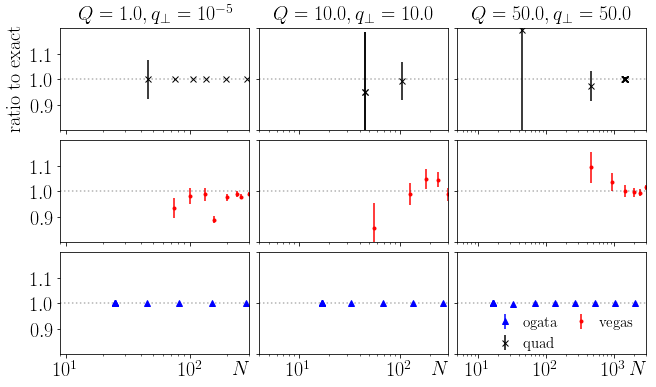

In [20]:
cwd = os.getcwd()
outdir = cwd
ncols,nrows=3,3
fig = py.figure(figsize=(ncols*3.5,nrows*2))

ax={}
ax[11]=py.subplot(nrows,ncols,1)
ax[12]=py.subplot(nrows,ncols,2)
ax[13]=py.subplot(nrows,ncols,3)
ax[21]=py.subplot(nrows,ncols,4)
ax[22]=py.subplot(nrows,ncols,5)
ax[23]=py.subplot(nrows,ncols,6)
ax[31]=py.subplot(nrows,ncols,7)
ax[32]=py.subplot(nrows,ncols,8)
ax[33]=py.subplot(nrows,ncols,9)

hquad  =ax[11].errorbar(data0['quad']['N'],data0['quad']['ratio'],data0['quad']['error'], fmt='kx')
hvegas =ax[21].errorbar(data0['vegas']['N'],data0['vegas']['ratio'],data0['vegas']['error'], fmt='r.')
hogata =ax[31].errorbar(data0['ogata']['N'],data0['ogata']['ratio'],data0['ogata']['error'], fmt='b^')

ax[12].errorbar(data1['quad']['N'],data1['quad']['ratio'],data1['quad']['error'], fmt='kx')
ax[22].errorbar(data1['vegas']['N'],data1['vegas']['ratio'],data1['vegas']['error'], fmt='r.')
ax[32].errorbar(data1['ogata']['N'],data1['ogata']['ratio'],data1['ogata']['error'], fmt='b^')

ax[13].errorbar(data2['quad']['N'],data2['quad']['ratio'],data2['quad']['error'], fmt='kx')
ax[23].errorbar(data2['vegas']['N'],data2['vegas']['ratio'],data2['vegas']['error'], fmt='r.')
ax[33].errorbar(data2['ogata']['N'],data2['ogata']['ratio'],data2['ogata']['error'], fmt='b^')


for k in ax: ax[k].axhline(1,color='k',alpha=0.3,ls=':')
for k in ax: ax[k].set_ylim(0,2)
for k in [11,12,13,21,22,23,31,32,33]:
    ax[k].semilogx()
for k in [11,21,31]: ax[k].set_xlim(9,300)
for k in [12,22,32]: ax[k].set_xlim(4,300)
for k in [13,23,33]: ax[k].set_xlim(5,3000)
for k in [12,22,32]: ax[k].set_yticklabels([])
for k in [13,23,33]: ax[k].set_yticklabels([])
for k in [11,21,12,22, 13, 23]: ax[k].set_xticklabels([])
#ax[32].set_xticks([100,200])
#ax[31].set_xticks([100,200])
#ax[33].set_xticks([200,600])
#ax[13].set_xticks([200,600])
#ax[23].set_xticks([200,600])
for k in [11,21,31]: ax[k].set_yticks([0.9,1.0,1.1])
for k in [11,21,31]: ax[k].set_ylim(0.8,1.2)
for k in [31,32,33]:
    ax[k].set_xlabel(r'$N$',size=20)    
    ax[k].xaxis.set_label_coords(0.95, -0.05)
ax[11].set_ylabel(r'$\rm ratio~to~exact$',size=20)    
ax[11].set_title(r'$Q=1.0,q_{\perp}=10^{-5}$',size=20)
ax[12].set_title(r'$Q=10.0,q_{\perp}=10.0$',size=20)
ax[13].set_title(r'$Q=50.0,q_{\perp}=50.0$',size=20)

#for k in ax: ax[k].text(0.8,0.8,r'$a$',transform=ax[k].transAxes)
for k in ax: ax[k].tick_params(axis='both', which='major', labelsize=20)
py.subplots_adjust(wspace=0.05, hspace=0.1)
ax[33].legend([hogata,hquad,hvegas],[r'$\rm ogata$',r'$\rm quad$',r'$\rm vegas$']\
              ,fontsize=15,handletextpad=.2,framealpha=1,loc=4,ncol=2\
              ,frameon=0,columnspacing=0.5,bbox_to_anchor=(1.0, -0.1))
py.show()
fig.savefig('gamma_convergence.pdf')
py.tight_layout()

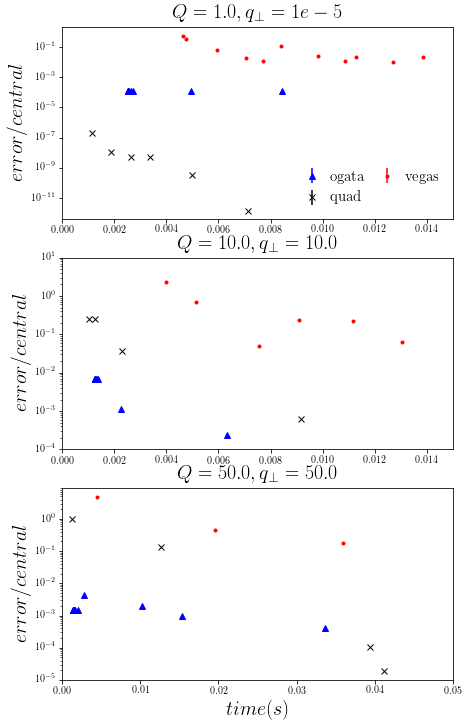

In [21]:
cwd = os.getcwd()
outdir = cwd
ncols,nrows=1,3
fig = py.figure(figsize=(ncols*3.5*2,nrows*4))

ax={}
ax[1]=py.subplot(nrows,ncols,1)
ax[2]=py.subplot(nrows,ncols,2)
ax[3]=py.subplot(nrows,ncols,3)

#fquad0=interp1d(data0['quad']['time'], [abs(data0['quad']['error'][i]/data0['quad']['ratio'][i]) for i in range(len(data0['quad']['ratio']))], kind='linear')
#quad0xnew = np.linspace(data0['quad']['time'][0], data0['quad']['time'][-1], num=100, endpoint=True)

#fvegas0=interp1d(data0['vegas']['time'], [abs((1-data0['vegas']['ratio'][i])/data0['vegas']['ratio'][i]) for i in range(len(data0['vegas']['ratio']))], kind='cubic')
#vegas0xnew = np.linspace(data0['vegas']['time'][0], data0['vegas']['time'][-1], num=100, endpoint=True)

#fogata0=interp1d(data0['quad']['time'], [abs(data0['quad']['error'][i]/data0['quad']['ratio'][i]) for i in range(len(data0['quad']['ratio']))], kind='linear')
#quad0xnew = np.linspace(data0['quad']['time'][0], data0['quad']['time'][-1], num=100, endpoint=True)

#vals=np.linspace(0.01,0.03,100)
#def newcurve(a,b,x):
#    return a/x+b

#ax[1].errorbar(quad0xnew,fquad0(quad0xnew),[0.0]*len(quad0xnew))
ax[1].errorbar(data0['quad']['time'][1:],[abs(1.0-data0['quad']['ratio'][i]) for i in range(len(data0['quad']['ratio']))][1:],[0]*(len(data0['quad']['ratio'])-1), fmt='kx')#
ax[1].errorbar(data0['vegas']['time'],[abs(1.0-data0['vegas']['ratio'][i]) for i in range(len(data0['vegas']['ratio']))],[0]*len(data0['vegas']['ratio']), fmt='r.')
#ax[1].errorbar(vegas0xnew,fvegas0(vegas0xnew))
#ax[1].plot(data0['vegas']['time'],[newcurve(1.0,-10.0,data0['vegas']['time'][i]) for i in range(len(data0['vegas']['time']))])
ax[1].errorbar(data0['ogata']['time'][1:-5],[abs(1.0-data0['ogata']['ratio'][i]) for i in range(len(data0['ogata']['ratio']))][1:-5],[0]*(len(data0['ogata']['ratio'])-6), fmt='b^')

ax[2].errorbar(data1['quad']['time'],[abs(1.0- data1['quad']['ratio'][i]) for i in range(len( data1['quad']['ratio']))], [0]*len(data1['quad']['ratio']), fmt='kx')
ax[2].errorbar(data1['vegas']['time'],[abs(1.0-data1['vegas']['ratio'][i]) for i in range(len(data1['vegas']['ratio']))],[0]*len(data1['vegas']['ratio']), fmt='r.')
ax[2].errorbar(data1['ogata']['time'],[abs(1.0-data1['ogata']['ratio'][i]) for i in range(len(data1['ogata']['ratio']))],[0]*len(data1['ogata']['ratio']), fmt='b^')
quaderror=[0]*len(data2['quad']['ratio'])
ax[3].errorbar(data2['quad']['time'][6:],[abs(1.0- data2['quad']['ratio'][i]) for i in range(len( data2['quad']['ratio']))][6:], quaderror[6:], fmt='kx')
ax[3].errorbar(data2['vegas']['time'],[abs(1.0-data2['vegas']['ratio'][i]) for i in range(len(data2['vegas']['ratio']))],[0]*len(data2['vegas']['ratio']), fmt='r.')
ax[3].errorbar(data2['ogata']['time'],[abs(1.0-data2['ogata']['ratio'][i]) for i in range(len(data2['ogata']['ratio']))],[0]*len(data2['ogata']['ratio']), fmt='b^')

#ax[2].errorbar(data1['quad']['time'],[abs((1.0-data1['quad']['ratio'][i])/data1['quad']['ratio'][i]) for i in range(len(data1['quad']['ratio']))],[0]*len(data1['quad']['ratio']), fmt='kx')
#ax[2].errorbar(data1['vegas']['time'],[abs((1.0-data1['vegas']['ratio'][i])/data1['vegas']['ratio'][i]) for i in range(len(data1['vegas']['ratio']))],[0]*len(data1['vegas']['ratio']), fmt='r.')
#ax[2].errorbar(data1['ogata']['time'],[abs((1.0-data1['ogata']['ratio'][i])/data1['ogata']['ratio'][i]) for i in range(len(data1['ogata']['ratio']))],[0]*len(data1['ogata']['ratio']), fmt='b^')

#ax[3].errorbar(data2['quad']['time'],[abs((1.0-data2['quad']['ratio'][i])/data2['quad']['ratio'][i]) for i in range(len(data2['quad']['ratio']))],[0]*len(data2['quad']['ratio']), fmt='kx')
#ax[3].errorbar(data2['vegas']['time'],[abs((1.0-data2['vegas']['ratio'][i])/data2['vegas']['ratio'][i]) for i in range(len(data2['vegas']['ratio']))],[0]*len(data2['vegas']['ratio']), fmt='r.')
#ax[3].errorbar(data2['ogata']['time'],[abs((1.0-data2['ogata']['ratio'][i])/data2['ogata']['ratio'][i]) for i in range(len(data2['ogata']['ratio']))],[0]*len(data2['ogata']['ratio']), fmt='b^')

for k in ax:
    ax[k].semilogy()

ax[1].set_xlim(0.0,0.015)
#ax[1].set_ylim(1e-9,1e0)
#ax[2].semilogx()
ax[2].set_xlim(0.0,0.015)
#ax[1].semilogx()
ax[2].set_ylim(1e-4,1e1)
ax[3].set_xlim(0,0.05)
#ax[3].set_ylim(2e-6,1e1)

#for k in [1,2]: ax[k].axhline(1,color='k',alpha=0.3,ls=':')
#ax[2].set_xticks([1e-3,1e-2,2e-2])
#ax[3].set_xticks([1e-3,1e-2,2e-2,3e-2,4e-2])
#for k in [1,2,3]: 
#    #ax[k].set_yticks([1e-0,1e-2,1e-4])
ax[3].set_xlabel(r'$time(s)$',size=20)
#    #ax[k].xaxis.set_label_coords(0.95, -0.05)
ax[1].set_ylabel(r'$error/central$',size=20)
ax[2].set_ylabel(r'$error/central$',size=20)    
ax[3].set_ylabel(r'$error/central$',size=20)    
ax[1].set_title(r'$Q=1.0,q_{\perp}=1e-5$',size=20)
ax[2].set_title(r'$Q=10.0,q_{\perp}=10.0$',size=20)
ax[3].set_title(r'$Q=50.0,q_{\perp}=50.0$',size=20)
ax[1].legend([hogata,hquad,hvegas],[r'$\rm ogata$',r'$\rm quad$',r'$\rm vegas$']\
              ,fontsize=15,handletextpad=.2,framealpha=1,loc=4,ncol=2\
              ,frameon=0,columnspacing=0.5)
py.show()
fig.savefig('gamma_convergence_time.pdf')
py.tight_layout()

In [28]:
def Wtilde(bT,Q,m):
    global counter
    counter += 1
    return 2*np.pi*2.0**(0.5-m/2.0)*np.exp(-0.5*m*Q**2*bT**2)*np.sqrt(m)*Q*(np.sqrt(m)*Q*bT)**m/spec.gamma(0.5+m/2.0)
def W(qT, Q, m):
    return spec.hyp1f1(0.5*(1+m), 1.0, -qT**2.0/2/Q**2/m)#/spec.gamma(0.5+m/2)

In [34]:
def gen_data(nu,Q,q,m,epss,ns_vegas,ns_ogata,eps_ogata,exact):
    global counter
    w = np.vectorize(lambda bT: Wtilde(bT, Q, m))

    data={}
    
    data['quad']={'N':[],'ratio':[],'error':[],'time':[]}
    for eps in epss:
        counter = 0
        t0 = time.time()
        result=Quadinversion(w, q, nu, eps)
        t1 = time.time()
        total = t1-t0
        data['quad']['N'].append(counter/2)
        data['quad']['ratio'].append(result[0]/exact)
        data['quad']['error'].append(result[1]/exact)
        data['quad']['time'].append(total)

    data['vegas']={'N':[],'ratio':[],'error':[],'time':[]}
    for n in ns_vegas:
        counter = 0
        t0 = time.time()
        result=MCinversion(w, q, nu, int(n)/10)
        t1 = time.time()
        total = t1-t0
        data['vegas']['N'].append(counter/2)
        data['vegas']['ratio'].append(result[0]/exact)
        data['vegas']['error'].append(result[1]/exact)
        data['vegas']['time'].append(total)
        
    data['ogata']={'N':[],'ratio':[],'error':[],'time':[]}
    for n in ns_ogata:
        counter = 0
        t0 = time.time()
        result=adog(w, q, nu, int(int(n)/10), 1.0*Q)
        t1 = time.time()
        total = t1-t0
        data['ogata']['N'].append(int(counter/2))
        data['ogata']['ratio'].append(result[0]/exact)
        data['ogata']['error'].append(result[1]/exact)
        data['ogata']['time'].append(total)
        
    return data

In [35]:
nu = 0
Q = 1.0
q = 1e-5
m=0.507816
exact = W(q, Q, m)
epss=np.logspace(-12,3,18)#[::-1]
ns_vegas=np.arange(10,1010,100)
ns_ogata=np.logspace(np.log10(150),np.log10(100000),20)
eps_ogata=[0.001,0.0025,0.005,0.0075,0.001]
data0=gen_data(nu,Q,q,sigma,epss,ns_vegas,ns_ogata,eps_ogata,exact)

In [36]:
nu = 0
Q = 10.0
q = 10.0
m = 0.00454891
exact = W(q, Q, m)
epss=np.logspace(-12,0,13)
ns_vegas=np.arange(10,4010,50)
ns_ogata=np.logspace(np.log10(60),np.log10(5800),10)
eps_ogata=[0.1,0.25,0.5,0.75,0.9,1.0]
data1=gen_data(nu,Q,q,m,epss,ns_vegas,ns_ogata,eps_ogata,exact)

In [37]:
nu = 0
Q = 50.0
q = 50.0
m = 0.000181701
exact = W(q, Q, m)
imax = 100
epss=np.logspace(-13,2,14)
ns_vegas=np.arange(1,12001,150)
ns_ogata=np.logspace(np.log10(50),np.log10(6000),10)
eps_ogata=[0.1,0.25,0.5,0.75,0.9]
data2=gen_data(nu,Q,q,m,epss,ns_vegas,ns_ogata,eps_ogata,exact)

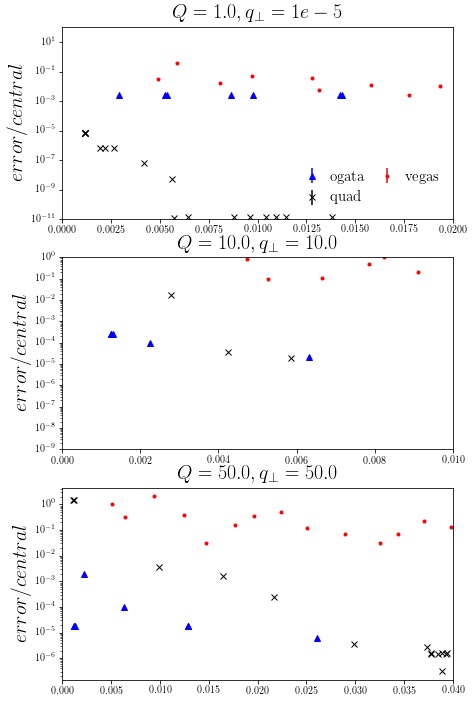

In [41]:
cwd = os.getcwd()
outdir = cwd
ncols,nrows=1,3
fig = py.figure(figsize=(ncols*3.5*2,nrows*4))

ax={}
ax[1]=py.subplot(nrows,ncols,1)
ax[2]=py.subplot(nrows,ncols,2)
ax[3]=py.subplot(nrows,ncols,3)



ax[1].errorbar(data0['quad']['time'],[abs( 1.0- data0['quad']['ratio'][i]) for i in range(len( data0['quad']['ratio']))],[0]*len( data0['quad']['ratio']),  fmt='kx')
ax[1].errorbar(data0['vegas']['time'],[abs(1.0-data0['vegas']['ratio'][i]) for i in range(len(data0['vegas']['ratio']))],[0]*len(data0['vegas']['ratio']), fmt='r.')
ax[1].errorbar(data0['ogata']['time'],[abs(1.0-data0['ogata']['ratio'][i]) for i in range(len(data0['ogata']['ratio']))],[0]*len(data0['ogata']['ratio']), fmt='b^')

ax[2].errorbar(data1['quad']['time'],[abs( 1.0- data1['quad']['ratio'][i]) for i in range(len( data1['quad']['ratio']))], [0]*len(data1['quad']['ratio']),  fmt='kx')
ax[2].errorbar(data1['vegas']['time'],[abs(1.0-data1['vegas']['ratio'][i]) for i in range(len(data1['vegas']['ratio']))],[0]*len(data1['vegas']['ratio']), fmt='r.')
ax[2].errorbar(data1['ogata']['time'],[abs(1.0-data1['ogata']['ratio'][i]) for i in range(len(data1['ogata']['ratio']))],[0]*len(data1['ogata']['ratio']), fmt='b^')

ax[3].errorbar(data2['quad']['time'],[abs( 1.0- data2['quad']['ratio'][i]) for i in range(len( data2['quad']['ratio']))], [0]*len(data2['quad']['ratio']),  fmt='kx')
ax[3].errorbar(data2['vegas']['time'],[abs(1.0-data2['vegas']['ratio'][i]) for i in range(len(data2['vegas']['ratio']))],[0]*len(data2['vegas']['ratio']), fmt='r.')
ax[3].errorbar(data2['ogata']['time'],[abs(1.0-data2['ogata']['ratio'][i]) for i in range(len(data2['ogata']['ratio']))],[0]*len(data2['ogata']['ratio']), fmt='b^')

for k in ax:
    ax[k].semilogy()

ax[1].set_xlim(0,0.02)
ax[1].set_ylim(1e-11,1e2)
ax[2].set_xlim(0,0.01)
ax[2].set_ylim(1e-9,1e0)
ax[3].set_xlim(0,0.04)

#for k in [1,2]: ax[k].axhline(1,color='k',alpha=0.3,ls=':')
#ax[2].set_xticks([1e-3,1e-2,2e-2])
#ax[3].set_xticks([1e-3,1e-2,2e-2,3e-2,4e-2])
#for k in [2,3]: 
#    ax[k].set_yticks([1e-0,1e-2,1e-4])
#    ax[k].set_xlabel(r'$time(s)$',size=20)
    #ax[k].xaxis.set_label_coords(0.95, -0.05)
ax[1].set_ylabel(r'$error/central$',size=20)
ax[2].set_ylabel(r'$error/central$',size=20)    
ax[3].set_ylabel(r'$error/central$',size=20)    
ax[1].set_title(r'$Q=1.0,q_{\perp}=1e-5$',size=20)
ax[2].set_title(r'$Q=10.0,q_{\perp}=10.0$',size=20)
ax[3].set_title(r'$Q=50.0,q_{\perp}=50.0$',size=20)
ax[1].legend([hogata,hquad,hvegas],[r'$\rm ogata$',r'$\rm quad$',r'$\rm vegas$']\
              ,fontsize=15,handletextpad=.2,framealpha=1,loc=4,ncol=2\
              ,frameon=0,columnspacing=0.5)
py.show()
fig.savefig('gamma_convergence_gauss_time.pdf')
py.tight_layout()

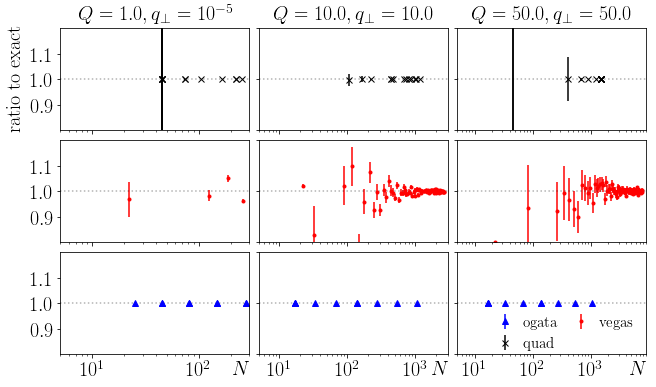

In [39]:
cwd = os.getcwd()
outdir = cwd
ncols,nrows=3,3
fig = py.figure(figsize=(ncols*3.5,nrows*2))

ax={}
ax[11]=py.subplot(nrows,ncols,1)
ax[12]=py.subplot(nrows,ncols,2)
ax[13]=py.subplot(nrows,ncols,3)
ax[21]=py.subplot(nrows,ncols,4)
ax[22]=py.subplot(nrows,ncols,5)
ax[23]=py.subplot(nrows,ncols,6)
ax[31]=py.subplot(nrows,ncols,7)
ax[32]=py.subplot(nrows,ncols,8)
ax[33]=py.subplot(nrows,ncols,9)



hquad  =ax[11].errorbar(data0['quad']['N'],data0['quad']['ratio'],data0['quad']['error'], fmt='kx')
hvegas =ax[21].errorbar(data0['vegas']['N'],data0['vegas']['ratio'],data0['vegas']['error'], fmt='r.')
hogata =ax[31].errorbar(data0['ogata']['N'],data0['ogata']['ratio'],data0['ogata']['error'], fmt='b^')

ax[12].errorbar(data1['quad']['N'],data1['quad']['ratio'],data1['quad']['error'], fmt='kx')
ax[22].errorbar(data1['vegas']['N'],data1['vegas']['ratio'],data1['vegas']['error'], fmt='r.')
ax[32].errorbar(data1['ogata']['N'],data1['ogata']['ratio'],data1['ogata']['error'], fmt='b^')

ax[13].errorbar(data2['quad']['N'],data2['quad']['ratio'],data2['quad']['error'], fmt='kx')
ax[23].errorbar(data2['vegas']['N'],data2['vegas']['ratio'],data2['vegas']['error'], fmt='r.')
ax[33].errorbar(data2['ogata']['N'],data2['ogata']['ratio'],data2['ogata']['error'], fmt='b^')


for k in ax: ax[k].axhline(1,color='k',alpha=0.3,ls=':')
for k in ax: ax[k].set_ylim(0,2)
for k in [11,12,13,21,22,23,31,32,33]:
    ax[k].semilogx()
for k in [11,21,31]: ax[k].set_xlim(5,300)
for k in [12,22,32]: ax[k].set_xlim(5,3000)
for k in [13,23,33]: ax[k].set_xlim(5,9000)
for k in [12,22,32]: ax[k].set_yticklabels([])
for k in [13,23,33]: ax[k].set_yticklabels([])
for k in [11,21,12,22, 13, 23]: ax[k].set_xticklabels([])
#ax[32].set_xticks([100,200])
#ax[31].set_xticks([100,200])
#ax[33].set_xticks([200,600])
#ax[13].set_xticks([200,600])
#ax[23].set_xticks([200,600])
for k in [11,21,31]: ax[k].set_yticks([0.9,1.0,1.1])
for k in [11,21,31]: ax[k].set_ylim(0.8,1.2)
for k in [31,32,33]:
    ax[k].set_xlabel(r'$N$',size=20)    
    ax[k].xaxis.set_label_coords(0.95, -0.05)
ax[11].set_ylabel(r'$\rm ratio~to~exact$',size=20)    
ax[11].set_title(r'$Q=1.0,q_{\perp}=10^{-5}$',size=20)
ax[12].set_title(r'$Q=10.0,q_{\perp}=10.0$',size=20)
ax[13].set_title(r'$Q=50.0,q_{\perp}=50.0$',size=20)

#for k in ax: ax[k].text(0.8,0.8,r'$a$',transform=ax[k].transAxes)
for k in ax: ax[k].tick_params(axis='both', which='major', labelsize=20)
py.subplots_adjust(wspace=0.05, hspace=0.1)
ax[33].legend([hogata,hquad,hvegas],[r'$\rm ogata$',r'$\rm quad$',r'$\rm vegas$']\
              ,fontsize=15,handletextpad=.2,framealpha=1,loc=4,ncol=2\
              ,frameon=0,columnspacing=0.5,bbox_to_anchor=(1.0, -0.1))
py.show()
fig.savefig('gamma_convergence_gauss.pdf')
py.tight_layout()

In [ ]:
counter =0
bT=np.logspace(-2,1,400)
m=2.28909
Q=0.5
Wb05=[Wtilde(b,Q,m) for b in bT]
m=0.507816
Q=1.0
Wb1=[Wtilde(b,Q,m) for b in bT]
Q=2.0
m=0.117518
Wb2=[Wtilde(b,2.0,1.0) for b in bT]
qT=np.logspace(-1,1,100)
Wq05=[W(q, 0.5, 1.0) for q in qT]
Wq1=[W(q, 1.0, 1.0) for q in qT]
Wq2=[W(q, 2.0, 1.0) for q in qT]
fig = py.figure(figsize=(8, 4))
ax=py.subplot(121)
#ax.plot(bT,Wb,label='Gamma')
ax.plot(bT,Wb2,label=r'$Q = 2.0$')
ax.plot(bT,Wb1,label=r'$Q = 1.0$',ls = '--')
ax.plot(bT,Wb05,label=r'$Q = 0.5$',ls = '-.')
ax.set_xlabel(r'$b_{\perp}$',fontsize=18)
ax.set_ylabel(r'$\widetilde{W}_G(b_{\perp})$',fontsize=18)
ax.semilogx()
ax=py.subplot(122)
ax.plot(qT,Wq2,label='Q = 2.0')
ax.plot(qT,Wq1,label='Q = 1.0',ls = '--')
ax.plot(qT,Wq05,label='Q = 0.5',ls = '-.')
ax.semilogx()
ax.legend()
ax.set_xlabel(r'$q_{\perp}',fontsize=18)
ax.set_ylabel(r'$W_{G 0}(q_{\perp})$',fontsize=18)
py.tight_layout()
py.savefig('FUU_gauss.pdf')
py.show()
#print W

In [21]:
from scipy.special import laguerre
from scipy.special import eval_laguerre as lag

In [2]:
def W(qT, Q, m):
    return spec.hyp1f1(m, 1.0, -qT**2.0/2/Q**2/m)

In [3]:
def vegas0(x, a, b, c):
    return a * b/(x)**c
vegas0x=[]
vegas0y=[]
xdata = data0['vegas']['time']
ydata = [abs((1.0-data0['vegas']['ratio'][i])/data0['vegas']['ratio'][i]) for i in range(len(data0['vegas']['ratio']))]
for i in range(len(xdata)):
    if ydata[i]<10**(-0.5):
        vegas0x.append(xdata[i])
        vegas0y.append(ydata[i])
ax=py.subplot(111)
ax.errorbar(vegas0x,vegas0y,[0]*len(vegas0x), fmt='k.')
ax.semilogy()
vegasopt, vegascov = curve_fit(vegas0, vegas0x, vegas0y)
ax.plot(vegas0x, vegas0(vegas0x, *vegasopt), 'r-')
py.show()

NameError: name 'data0' is not defined

In [131]:
data0={'quad': {'error': [1.1102230246251561e-15, 1.665889648703895e-12, 8.26336887930674e-10, 9.37726680703349e-08, 9.476903352462899e-07, 7.796927181936521e-06, 0.0020158336973298695, 0.07713001660577298], 'ratio': [0.9999999999999997, 0.9999999999999998, 0.9999999999984871, 1.0000000003351839, 1.0000000052620193, 1.0000000052633797, 0.999999988192263, 1.0000002091565556], 'time': [0.012850594520568848, 0.009345793724060058, 0.006772303581237793, 0.0047780036926269535, 0.0031306982040405274, 0.0023744821548461912, 0.0015643119812011718, 0.0010908842086791992], 'N': [465.05, 375.05, 285.05, 195.05, 135.05, 105.05, 75.05, 45.05]}, 'vegas': {'error': [0.30338175760886077, 0.08254612170240025, 0.048964256778929925, 0.03210633550871408, 0.023927318414367436, 0.01834739747139957, 0.01486416918257245, 0.010910493676981256, 0.009452367428893497, 0.008252147088148571, 0.007328927254896952], 'ratio': [3.270234244567203, 1.0137713868812614, 1.0735921959184545, 0.9883373101310436, 0.9835366899283664, 0.9846281025712953, 0.9882241499619494, 0.993208983893615, 0.9955263328359186, 0.9958325515298201, 0.9966102471633084], 'time': [0.005364592599868774, 0.00740987069606781, 0.009717240285873414, 0.012611590099334716, 0.015353145003318787, 0.0177570170879364, 0.01954584619998932, 0.02306821300983429, 0.02526264522075653, 0.027631990098953247, 0.030627470898628235], 'N': [22.0, 32.0, 53.9044, 97.761, 128.7336, 157.6774, 185.0412, 228.3171, 258.1831, 287.8056, 317.301]}, 'ogata': {'error': [5.7863551019956486e-43, 5.7863551019956486e-43, 2.1058372521868138e-38, 8.042929981491426e-36, 1.1052428208091787e-35, 4.198623189964517e-36, 1.1648488998018456e-36, 5.926097337733857e-37, 1.5009084066118273e-37, 3.7644830844660296e-38], 'ratio': [1.0001303196922338, 1.0001303196922338, 1.0000051947996442, 1.0000000166021534, 1.0000000000640537, 1.000000000000256, 1.0000000000000007, 0.9999999999999997, 0.9999999999999994, 0.9999999999999994], 'time': [0.0024480819702148438, 0.0025391578674316406, 0.004105091094970703, 0.01299905776977539, 0.03740406036376953, 0.09605693817138672, 0.2321329116821289, 0.3562448024749756, 0.871574878692627, 2.7380001544952393], 'N': [19, 19, 32, 90, 292, 1070, 4152, 8253, 32839, 131153]}}
data1={'quad': {'error': [0.00016423971226315882, 0.0001642395988503322, 3.2717881380656005e-05, 7.97196190872547e-10, 8.837219453347827e-08, 8.117415937506e-06, 3.038609069800459e-05, 0.0003518535255887552, 0.005553502089588646, 0.06615105364550763, 0.3771312276841934], 'ratio': [0.9999974269314336, 0.9999974266827172, 0.9999999961955945, 0.9999999959356769, 0.9999999959356616, 1.0000001043154711, 0.9999806486219404, 0.9999859015372378, 0.999895535295984, 1.0022778693238104, 0.9632097069499865], 'time': [0.0413686990737915, 0.03553531169891357, 0.03542790412902832, 0.034183597564697264, 0.029343509674072267, 0.02248997688293457, 0.01866919994354248, 0.015425515174865723, 0.01285550594329834, 0.007151913642883301, 0.0025495052337646484], 'N': [1485.05, 1485.05, 1485.05, 1395.05, 1185.05, 885.05, 735.05, 615.05, 525.05, 285.05, 105.05]}, 'vegas': {'error': [91.75100351600923, 201.60281224238813, 18.89774553165289, 9.596261900297456, 0.15082913794770708, 0.12631179087719266, 0.10101928774375121, 0.09172569657033942, 0.07774715932307665, 0.06948810335674031], 'ratio': [74.59058662042752, 17.839296080925035, 1.109940176528977, 1.048846999077827, 1.0191118620127946, 1.014433360022545, 1.0102313906689557, 1.0067007170011097, 1.0040762289137635, 1.003983915534378], 'time': [0.021610043001174927, 0.024315902996063232, 0.027900752997398377, 0.03084761471748352, 0.03440008010864258, 0.039381303310394286, 0.0406986065864563, 0.045105094718933106, 0.051374525690078734, 0.054362674188613895], 'N': [22.0, 53.914, 119.4652, 174.7103, 245.0416, 301.9022, 373.7871, 432.5865, 504.5342, 563.4301]}, 'ogata': {'error': [-0.0043696814362793965, -0.0005509972545252096, 0.0002700040594650096, -2.618247442482738e-10, -3.70549853974293e-12, 4.548337117492059e-12, 3.498169603811894e-13, 8.855343893359886e-14, 1.0650804222662235e-13, 7.907143599896044e-14, 4.7183231746650984e-14, 2.5640771242199668e-14, 1.3348806530218435e-14, 6.8084502925190486e-15, 3.4379746061110034e-15], 'ratio': [1.00532047486407, 1.0014365452209302, 1.0002250343791164, 1.0002613284764004, 1.0000575378781582, 1.0000128701381543, 1.0000028960478817, 1.0000006533254884, 1.0000001475574538, 1.0000000333468908, 1.0000000075399336, 1.00000000170679, 1.0000000003881158, 1.000000000089981, 1.0000000000225715], 'time': [0.00090789794921875, 0.0013339519500732422, 0.0045359134674072266, 0.011023998260498047, 0.019168853759765625, 0.036051034927368164, 0.06482791900634766, 0.10174894332885742, 0.1479640007019043, 0.2166271209716797, 0.35225391387939453, 0.5434088706970215, 0.9184060096740723, 1.604464054107666, 2.9815540313720703], 'N': [9, 17, 38, 75, 144, 277, 538, 1055, 2084, 4137, 8238, 16435, 32824, 65597, 131138]}}
data2={'quad': {'error': [0.03852304705920816, 0.024148164889268287, 0.01066823951835481, 7.116286738162232], 'ratio': [1.0039430076361344, 1.0023844138684068, 0.9999810369954172, 1.9682390126866103], 'time': [0.03972659111022949, 0.03763577938079834, 0.033038783073425296, 0.0009920120239257813], 'N': [1485.05, 1485.05, 1485.05, 45.05]}, 'vegas': {'N': [22.0, 469.7672, 954.0048, 1454.7108, 1963.0299, 2479.8849, 3001.7164, 3527.22, 4056.074, 4589.2882], 'time': [0.032695806694030764, 0.049881547689437866, 0.06786613349914551, 0.21918909990787505, 0.11485900130271912, 0.1231822900056839, 0.1532144273996353, 0.17404665501117705, 0.18331420269012452, 0.19768976769447327], 'ratio': [367.84006921262704, 40.569091266796434, 1.0160393922187174, 1.0085241831544043, 1.0034899297885675, 1.0014790900662909, 1.00168954903971, 1.0003704561057722, 1.0007345671821366, 1.0001478246752389], 'error': [628.0889090742575, 157.99260796916585, 0.17594082835848454, 0.1189459794457536, 0.0888187651798215, 0.07028791166164776, 0.05753635972040749, 0.048083100880623245, 0.04193989257022753, 0.03674033733902498]}, 'ogata': {'N': [9, 17, 75, 277, 538, 2084, 8238, 16435, 65597, 262215], 'time': [0.0008001327514648438, 0.0011599063873291016, 0.00938105583190918, 0.03276491165161133, 0.05923795700073242, 0.13056707382202148, 0.29641222953796387, 0.46611809730529785, 1.3766610622406006, 5.0601091384887695], 'ratio': [0.9812291604391767, 1.0091238741292294, 0.9983173719315273, 1.0002714080486053, 1.000473024710833, 1.000466188476558, 1.0004413568929835, 1.0004340910366751, 1.0004279163039467, 1.000426270826803], 'error': [-0.05728722021930712, -0.030697770539287135, -0.003188490908364063, 0.0006080165379194054, 5.0938418085450984e-05, 1.547627435300078e-05, 6.792226955261638e-06, 3.6840983847367883e-06, 9.767928868979559e-07, 2.4773966365538736e-07]}}


In [41]:
print data2

{'quad': {'error': [0.03852304705920816, 0.024148164889268287, 0.01066823951835481, 7.116286738162232], 'ratio': [1.0039430076361344, 1.0023844138684068, 0.9999810369954172, 1.9682390126866103], 'time': [0.03972659111022949, 0.03763577938079834, 0.033038783073425296, 0.0009920120239257813], 'N': [1485.05, 1485.05, 1485.05, 45.05]}, 'vegas': {'N': [22.0, 469.7672, 954.0048, 1454.7108, 1963.0299, 2479.8849, 3001.7164, 3527.22, 4056.074, 4589.2882], 'time': [0.032695806694030764, 0.049881547689437866, 0.06786613349914551, 0.21918909990787505, 0.11485900130271912, 0.1231822900056839, 0.1532144273996353, 0.17404665501117705, 0.18331420269012452, 0.19768976769447327], 'ratio': [367.84006921262704, 40.569091266796434, 1.0160393922187174, 1.0085241831544043, 1.0034899297885675, 1.0014790900662909, 1.00168954903971, 1.0003704561057722, 1.0007345671821366, 1.0001478246752389], 'error': [628.0889090742575, 157.99260796916585, 0.17594082835848454, 0.1189459794457536, 0.0888187651798215, 0.07028791

In [16]:
print True and True

True
